In [1]:
### Initial notebook

In [2]:
#%pip install xarray
!python -c "import sys; print(sys.version)"

3.12.1 (main, Jan  1 1980, 12:01:00) [GCC 13.2.0]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import cartopy.crs as ccrs
import pandas as pd
from itertools import groupby
import glob
import os
import time
import xarray as xr
from contrack import contrack
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, TwoSlopeNorm
import uxarray as ux

In [4]:
## Climate indices
def count_frost_days(tn, threshold=0.0):
    '''
    Annual count of days when TN (daily minimum temperature) < 0oC.

    Let TNijbe daily minimum temperature on day i in year j. Count the number of days where:

    TNij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tn_clean = tn.where(np.isfinite(tn))

    # Frost day mask and count
    frost_days = (tn_clean < threshold)
#    return frost_days.sum(dim='time', skipna=True)
    # Convert boolean to float (True=1.0, False=0.0), and sum over time
    return frost_days.astype(float).sum(dim='time', skipna=True)

def count_summer_days(tm, threshold=25.0):
    '''
    SU, Number of summer days: Annual count of days when TX (daily maximum temperature) > 25oC.

    Let TXij be daily maximum temperature on day i in year j. Count the number of days where:
    TXij > 25oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    summer_days = (tm_clean > threshold)
    return summer_days.sum(dim='time', skipna=True)

def count_icing_days(tm, threshold=0.0):
    '''
    ID, Number of icing days: Annual count of days when TX (daily maximum temperature) < 0oC.

    Let TXijbe daily maximum temperature on day i in year j. Count the number of days where:

    TXij < 0oC.
    '''
    # Clean data (handle any non-finite values safely)
    tm_clean = tm.where(np.isfinite(tm))

    # Assume °C by default, adjust only if unit says Kelvin
 #   if tn_clean.attrs.get('units', '').lower() in ['k', 'kelvin']:
 #       threshold += 273.15

    # Frost day mask and count
    icing_days = (tm_clean < threshold)
    return icing_days.sum(dim='time', skipna=True)
#def compute_TXX(tmax):
#    return tmax.groupby('time.year').max(dim='time')

def compute_dtr(tx, tn):
    """
    Compute Daily Temperature Range (DTR) as the monthly mean of (TX - TN).

    Parameters:
        tx (xarray.DataArray): Daily maximum temperature (TX), with 'time' dimension.
        tn (xarray.DataArray): Daily minimum temperature (TN), same dimensions as tx.

    Returns:
        xarray.DataArray: Monthly mean daily temperature range.
    """
    # Ensure both inputs align in time and space
    tx, tn = xr.align(tx, tn)

    # Compute daily range
    dtr_daily = tx - tn

    # Compute monthly mean DTR
    dtr_monthly = dtr_daily.resample(time='ME').mean(dim='time', skipna=True)

    # Add metadata
    dtr_monthly.name = 'DTR'
    dtr_monthly.attrs.update({
        'long_name': 'Monthly mean daily temperature range',
        'units': tx.attrs.get('units', '°C'),
        'comment': 'Mean of daily (TX - TN), where TX is max and TN is min temperature.',
        'cell_methods': 'time: mean (of daily max - min)',
    })

    return dtr_monthly
def get_max_dry_spell(seq):
    """
    Get the length of the longest consecutive run of True (dry days) in a 1D boolean array.
    """
    return max((sum(1 for _ in group) for val, group in groupby(seq) if val), default=0)


def compute_CDD(precip, threshold=1.0):
    """
    Compute the maximum length of dry spells (CDD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CDD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip < threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive dry days',
        'units': 'days',
        'comment': 'CDD is the length of the longest dry spell (RR < 1 mm)',
    })

    return cdd,dry_days

def compute_CWD(precip, threshold=1.0):
    """
    Compute the maximum length of wet spells (CWD) using groupby logic.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation with time dim.
        threshold (float): Dry day threshold in mm (default: 1.0).
    
    Returns:
        xarray.DataArray: CWD values (max dry spell length) at each grid point.
    """
    # Get dry day mask
    dry_days = (precip > threshold)

#    dry_days=dry_days.astype(float)

    # Apply the get_max_dry_spell function along 'time' using xarray.apply_ufunc
    cdd = xr.apply_ufunc(
        get_max_dry_spell,
        dry_days,
        input_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[int]
    )

    cdd.name = 'CDD'
    cdd.attrs.update({
        'long_name': 'Maximum number of consecutive wet days',
        'units': 'days',
        'comment': 'CWD is the length of the longest wet spell (RR > 1 mm)',
    })

    return cwd,wet_days

def compute_precip_exceedance(precip, start='2010', end='2023', bin_width=0.01, max_precip=1000):
    """
    Compute exceedance frequency of daily precipitation.
    
    Parameters:
        precip (xarray.DataArray): Daily precipitation (mm/day), must have 'time' dim.
        start (str): Start year.
        end (str): End year.
        bin_width (float): Width of precipitation bins (mm/day).
        max_precip (float): Upper limit of precipitation to consider (mm/day).
    
    Returns:
        bins (np.ndarray): Precipitation bin edges.
        exceedance_freq (np.ndarray): Exceedance frequency (%) for each bin.
    """
    # Select time slice
    p = precip.sel(time=slice(start, end))
    
    # Flatten across time and space
    values = p.values.flatten()
    values = values[np.isfinite(values)]  # Remove NaNs

    # Define bins
    bins = np.arange(0, max_precip + bin_width, bin_width)

    # Histogram (counts of values in each bin)
    hist, bin_edges = np.histogram(values, bins=bins)

    # Cumulative sum (reverse): exceedance count
    exceedance_counts = np.cumsum(hist[::-1])[::-1]

    # Convert to percentage
    exceedance_freq = 100 * exceedance_counts / exceedance_counts[0]

    return bins[:-1], exceedance_freq

# 2.5km resolution

In [27]:
###Unstructured grid
us_xr=xr.open_dataset('/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_2/tot_prec_20240325T000000Z.nc',chunks="auto")
us_xr

#icon_grid_path = "/capstor/scratch/cscs/ppothapa/for_edgar/sou_s_20230817T000000Z.nc"
#uxgrid = ux.open_grid(icon_grid_path)
#uxgrid

#icon_grid_path = "/capstor/scratch/cscs/edolores/old_icon/icon_grid_0056_R02B10_G.nc"
#icon_file_path = '/capstor/store1/cscs/userlab/cwp03/zemanc/Data_Dyamond_PostProcessed/out_2/tot_prec_20240325T000000Z.nc'
#ux_ds = ux.open_dataset( icon_grid_path, icon_file_path)
#ux_ds 

<xarray.Dataset> Size: 38GB
Dimensions:    (ncells: 83886080, vertices: 3, time: 96)
Coordinates:
  * time       (time) datetime64[ns] 768B 2024-03-25 ... 2024-03-25T23:45:00
    clon       (ncells) float64 671MB dask.array<chunksize=(16777216,), meta=np.ndarray>
    clat       (ncells) float64 671MB dask.array<chunksize=(16777216,), meta=np.ndarray>
Dimensions without coordinates: ncells, vertices
Data variables:
    clon_bnds  (ncells, vertices) float64 2GB dask.array<chunksize=(16777216, 1), meta=np.ndarray>
    clat_bnds  (ncells, vertices) float64 2GB dask.array<chunksize=(16777216, 1), meta=np.ndarray>
    tot_prec   (time, ncells) float32 32GB dask.array<chunksize=(1, 13983744), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 2.4.0 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  17
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/ic...
    uuidOfHGrid:          36d404b8-7551-11e8-b1af-17a1ae0ab23a
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               version: 2024.10; revision: spack-ci_v0.1-1084-g087...
    history:              ./icon at 20250731 010223
    references:           see MPIM/DWD publications
    comment:              Praveen Kumar Pothapakula, ETHZ (ppothapa) on nid00...

In [30]:
#### Unstructured grid
#gt2m=xr_in['t_2m'].isel(height_2=0 ).resample(time='D').mean()
### remapped
#gt2m=xr_in['t_2m'].isel(height=0 ).resample(time='D').mean()

In [28]:
### reordering file
'''
ds=xr.open_dataset('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_2024_0p5deg.nc')

# 3) Choose the main data variable (edit if you know its name)
#var = [v for v in ds.data_vars][]  # e.g., 't2m'
var ='t2m'

# --- 2) Whitelist variable attrs you want to keep ---
keep_var_attrs = {"long_name", "units", "cell_methods","institution"}  # adjust as needed
# Drop everything else (including GRIB_* and 'standard_name' if you don't want it)
new_attrs = {k: v for k, v in ds[var].attrs.items() if k in keep_var_attrs}
ds[var].attrs = new_attrs

# 2) Unify dim/coord names to exactly: time, lat, lon
rename = {}
for d in ds.dims:
    if d.lower() in ["latitude", "y"]:
        rename[d] = "lat"
    elif d.lower() in ["longitude", "x"]:
        rename[d] = "lon"
    elif d.lower() in ["valid_time", "time", "t"]:
        rename[d] = "time"
ds = ds.rename(rename)

# 7) Set the requested attributes
# Variable-level attrs
ds[var].attrs.update({
    "long_name": "2 metre temperature",
    "units": "K",
    "cell_methods": "time: maximum",
    "institution" : "ECMWF"
})

ds['t2m'].to_netcdf('/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/tmp_t2m_day_2024_0p5deg.nc')
'''

'\nds=xr.open_dataset(\'/capstor/scratch/cscs/edolores/OBS/ERA5/TS_era5/t2m_day_2024_0p5deg.nc\')\n\n# 3) Choose the main data variable (edit if you know its name)\n#var = [v for v in ds.data_vars][]  # e.g., \'t2m\'\nvar =\'t2m\'\n\n# --- 2) Whitelist variable attrs you want to keep ---\nkeep_var_attrs = {"long_name", "units", "cell_methods","institution"}  # adjust as needed\n# Drop everything else (including GRIB_* and \'standard_name\' if you don\'t want it)\nnew_attrs = {k: v for k, v in ds[var].attrs.items() if k in keep_var_attrs}\nds[var].attrs = new_attrs\n\n# 2) Unify dim/coord names to exactly: time, lat, lon\nrename = {}\nfor d in ds.dims:\n    if d.lower() in ["latitude", "y"]:\n        rename[d] = "lat"\n    elif d.lower() in ["longitude", "x"]:\n        rename[d] = "lon"\n    elif d.lower() in ["valid_time", "time", "t"]:\n        rename[d] = "time"\nds = ds.rename(rename)\n\n# 7) Set the requested attributes\n# Variable-level attrs\nds[var].attrs.update({\n    "long_nam

In [20]:
da=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/TS/t2m_day_202*',{"time": 366, "lat": -1, "lon": -1})['t_2m'].squeeze()
da

<xarray.DataArray 't_2m' (time: 1534, lat: 181, lon: 720)> Size: 800MB
dask.array<getitem, shape=(1534, 181, 720), dtype=float32, chunksize=(365, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T11:30:00 ... 2024-04-01
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    height   float64 8B 2.0
Attributes:
    standard_name:  t_2m
    long_name:      temperature in 2m
    units:          K
    param:          0.0.0
    cell_methods:   time: mean

In [5]:
#Time series

In [6]:
icon_2km_month=da.resample(time='1M').mean()
#era5_month.mean(dim=['lat', 'lon']).plot()
icon_2km_month_mean = icon_2km_month.mean(dim=["lat", "lon"]) #.compute()

# >>> Key change: ensure time chunks are >= 12
icon_2km_month_mean = icon_2km_month_mean.chunk({'time': 120})

# 12-month (1 year) rolling mean
#the window length (rolling(time=N)) depending on how much smoothing you want (e.g., 6 for half-year, 24 for 2 years).
icon_2km_smooth = icon_2km_month_mean.rolling(time=12, center=True).mean() #.compute()

/users/edolores/.env_icon/lib/python3.12/site-packages/xarray/groupers.py:530: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


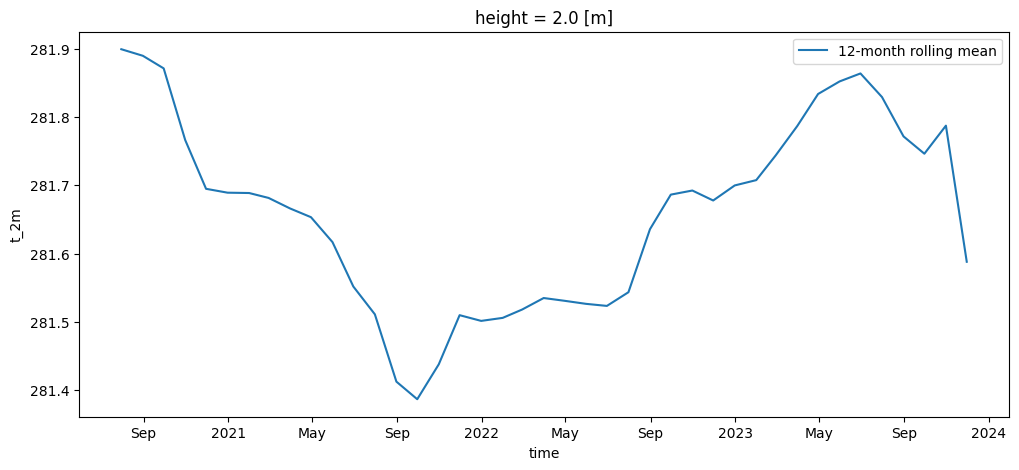

In [7]:
# Plot both raw monthly and smoothed
plt.figure(figsize=(12,5))
#icon_2km_month_mean.plot(label="Monthly mean")
icon_2km_smooth.plot(label="12-month rolling mean")
plt.legend()
plt.show()

In [8]:
### NH map mean

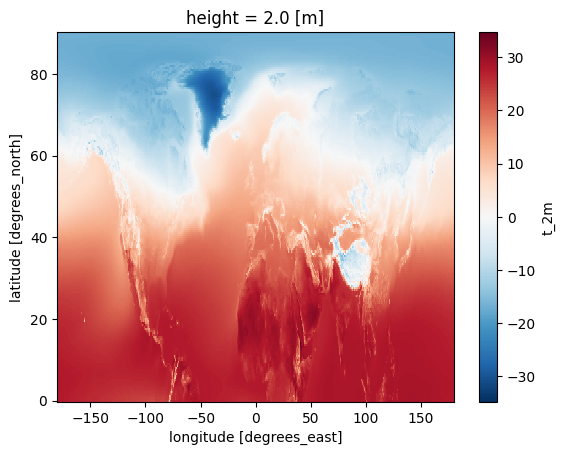

In [9]:
da_mean=(da-273.15).mean(dim=['time'])
da_mean.plot()

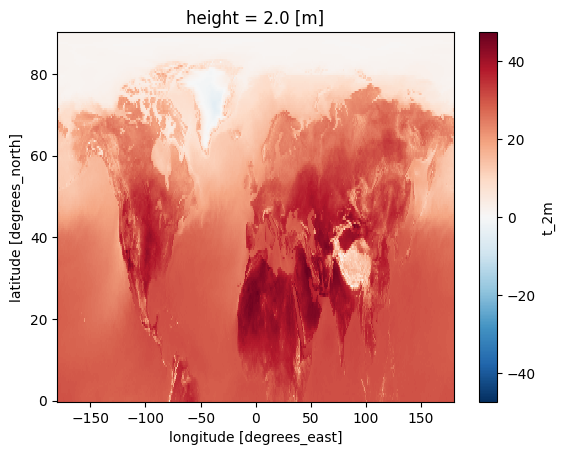

In [10]:
### max daily mean
da_max=(da-273.15).max(dim=['time'])
da_max.plot()

# Unstructured 40 km

In [25]:
#icon_grid_path = "/capstor/scratch/cscs/ppothapa/for_edgar/sou_s_20230817T000000Z.nc"
icon_grid_path = "/capstor/scratch/cscs/edolores/old_icon/icon_grid_0052_R02B06_G.nc"

icon_file_path = "/capstor/scratch/cscs/ppothapa/for_edgar/tot_prec/tot_prec_2017_compressed.nc"

ux_ds = ux.open_dataset( icon_grid_path, icon_file_path)
ux_ds 

<xarray.UxDataset> Size: 12GB
Dimensions:    (n_face: 327680, vertices: 3, time: 8760)
Coordinates:
  * time       (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
    clon       (n_face) float64 3MB ...
    clat       (n_face) float64 3MB ...
Dimensions without coordinates: n_face, vertices
Data variables:
    clon_bnds  (n_face, vertices) float64 8MB ...
    clat_bnds  (n_face, vertices) float64 8MB ...
    tot_prec   (time, n_face) float32 11GB ...

In [17]:
#uxgrid = ux.open_grid(icon_grid_path)
#uxgrid.dims

{'n_edge',
 'n_face',
 'n_max_face_edges',
 'n_max_face_faces',
 'n_max_face_nodes',
 'n_node',
 'two'}

In [18]:
ux_ds['tot_prec'].isel(time=0).plot(cmap="viridis", backend="bokeh") 

:Image   [x,y]   (x_y tot_prec)

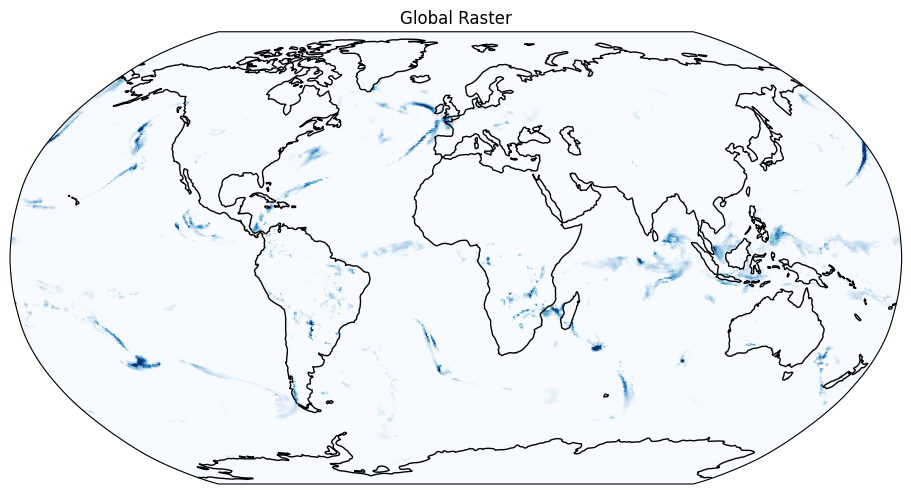

In [24]:
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.Robinson()}, figsize=(9, 6), constrained_layout=True
)

ax.set_global()
raster = ux_ds['tot_prec'].isel(time=0).to_raster(ax=ax)
img = ax.imshow(
    raster, cmap="Blues", vmax=5, vmin=0.5, origin="lower", extent=ax.get_xlim() + ax.get_ylim()
)
ax.set_title("Global Raster")
ax.coastlines()
